# Imports & Functions & Data Loading

In [1]:
from google.colab import drive
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
def check_and_remove_nans(df, df_name):
  """
  Prints the number of NaN values per column and removes rows containing NaNs.
  """

  nan_counts = df.isna().sum()
  nan_columns = nan_counts[nan_counts > 0]
  df_cleaned = df

  if not nan_columns.empty:
    print(f"\nMissing values per column in {df_name}:")
    print(nan_columns)

    df_cleaned = df.dropna()
    print(f"\n{df_name}: Removed {len(df) - len(df_cleaned)} row(s) with NaN values.")

  else:
    print(f"\n{df_name}: No missing values found.")

  return df_cleaned

In [3]:
def filetime_to_datetime(ft):
  """
  Convert FileTime to a human-readable datetime format.
  There were different functions to convert ID to datetime but this was the only one giving year 2010, which was mentioned in the assignment pdf, so I assumed this is correct.
  """
  return datetime(1, 1, 1) + timedelta(microseconds=ft // 10)

In [4]:
def dmm_to_decimal(dmm_value):
  """Convert Degrees and Decimal Minutes (DMM) to Decimal Degrees (DD)."""
  if isinstance(dmm_value, str) and len(dmm_value) > 3:

    if dmm_value[-1] in ["N", "S"]:
      degrees = int(dmm_value[:2])  # First 2 digits for latitude
      minutes = float(dmm_value[2:-1])  # minutes
      direction = dmm_value[-1]  # N/S direction
    elif dmm_value[-1] in ["E", "W"]:
      degrees = int(dmm_value[:3])  # First 3 digits for longitude
      minutes = float(dmm_value[3:-1])  # minutes
      direction = dmm_value[-1]  # E/W direction
    else:
      return None

    # Convert to decimal degrees
    decimal_degrees = degrees + (minutes / 60)

    # Negative sign for S and W directions
    if direction in ["S", "W"]:
      decimal_degrees = -decimal_degrees

    return decimal_degrees
  return None

In [5]:
def circular_mean(angles):
  angles = np.deg2rad(angles.dropna())
  mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
  return np.rad2deg(mean_angle)

In [6]:
# Evaluate model performance
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Validation Performance
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = mean_squared_error(y_val, y_val_pred)

    # Test Performance
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)

    print(f"\n📊 {model_name} Performance:")
    print(f"Validation R²: {val_r2:.4f}, Validation RMSE: {val_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")

    return {"Validation R²": val_r2, "Validation RMSE": val_rmse, "Test R²": test_r2, "Test RMSE": test_rmse}

In [7]:
drive.mount('/content/drive')

folder_path = "/content/drive/My Drive/ml_mp1_files" # This is the path of my folder containing .csv files.
# upload the files in your Drive and change this to your path for rerun.

Mounted at /content/drive


In [8]:
dataframes = {}

for file in os.listdir(folder_path):
  file_path = os.path.join(folder_path, file)

  df_name = file.replace(".csv", "")
  df = pd.read_csv(file_path, header=None, index_col=False)
  df.columns = ["ID", df_name]

  dataframes[df_name] = df
  print(f"Loaded {file} as {df_name}, shape: {df.shape}")

Loaded starboardPitch.csv as starboardPitch, shape: (1726076, 2)
Loaded portPitch.csv as portPitch, shape: (1726076, 2)
Loaded starboardRudder.csv as starboardRudder, shape: (1726076, 2)
Loaded portRudder.csv as portRudder, shape: (1726076, 2)
Loaded trackDegreeTrue.csv as trackDegreeTrue, shape: (1766479, 2)
Loaded speedKmh.csv as speedKmh, shape: (1766906, 2)
Loaded windAngle.csv as windAngle, shape: (863755, 2)
Loaded level2median.csv as level2median, shape: (3840794, 2)
Loaded trueHeading.csv as trueHeading, shape: (1439539, 2)
Loaded level1median.csv as level1median, shape: (3979774, 2)
Loaded windSpeed.csv as windSpeed, shape: (863755, 2)
Loaded speedKnots.csv as speedKnots, shape: (1766908, 2)
Loaded longitudinalWaterSpeed.csv as longitudinalWaterSpeed, shape: (548292, 2)
Loaded inclinometer-raw.csv as inclinometer-raw, shape: (3559677, 2)
Loaded trackDegreeMagnetic.csv as trackDegreeMagnetic, shape: (1766474, 2)
Loaded fuelTemp.csv as fuelTemp, shape: (1627324, 2)
Loaded fuelDe

# Data Preprocessing

I firstly tried to merge all data in one dataframe but my runtime got disconnected due to high RAM usage. Thus, I combined .csv files having same number of rows and did the preprocessing first. In the end, I merged all the data in one dataframe. So, excuse my repetitive code.

## Fuel-Related

In [9]:
fuel_keys = ["fuelDensity", "fuelTemp", "fuelVolumeFlowRate"]

# Initialize the merged fuel DataFrame
fuel_df = dataframes[fuel_keys[0]]

# Merge all other fuel-related dataframes using ID
for key in fuel_keys[1:]:
    fuel_df = pd.merge(fuel_df, dataframes[key], on="ID", how="outer")

fuel_df['Timestamp'] = fuel_df['ID'].apply(filetime_to_datetime)
fuel_df.drop(columns=['ID'], inplace=True)
fuel_df = fuel_df[['Timestamp'] + [col for col in fuel_df.columns if col != 'Timestamp']]

In [10]:
fuel_df

,Timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate
0,2010-02-16 10:50:11.922539,0.947109,62.20651,0.000000
1,2010-02-16 10:50:12.959761,0.947110,62.20406,0.000000
2,2010-02-16 10:50:13.982166,0.947114,62.19989,0.000000
3,2010-02-16 10:50:15.003604,0.947104,62.20412,0.000000
4,2010-02-16 12:48:13.560685,0.938305,86.89216,0.283816
...,...,...,...,...
1627319,2010-04-12 22:25:12.142861,0.930151,96.70869,0.203576
1627320,2010-04-12 22:25:13.164265,0.930103,96.75071,0.205217
1627321,2010-04-12 22:25:14.186664,0.930075,96.76398,0.212853
1627322,2010-04-12 22:25:15.208071,0.930082,96.76657,0.224660


In [11]:
# Clean fuel_df
fuel_df = check_and_remove_nans(fuel_df, df_name="fuel_df")


fuel_df: No missing values found.


I actually was going to do daily-based prediction. But, after observing that there are only 60 days in this dataset, I thought there was not enough data for that and switched to hourly-based prediction.

In [12]:
fuel_df['Hour'] = fuel_df['Timestamp'].dt.floor('h')
fuel_df = fuel_df.drop(columns=['Timestamp'])
# Aggregate by hour
hourly_fuel_df  = fuel_df.groupby('Hour').mean().reset_index()

# Display the aggregated daily fuel dataset
hourly_fuel_df

<ipython-input-12-8229b40ba6b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuel_df['Hour'] = fuel_df['Timestamp'].dt.floor('h')


,Hour,fuelDensity,fuelTemp,fuelVolumeFlowRate
0,2010-02-16 10:00:00,0.947109,62.203645,0.000000
1,2010-02-16 12:00:00,0.931464,92.897298,0.470666
2,2010-02-16 13:00:00,0.926195,97.423365,0.501743
3,2010-02-16 14:00:00,0.925123,98.076956,0.499402
4,2010-02-16 15:00:00,0.925057,98.096868,0.387270
...,...,...,...,...
683,2010-04-12 18:00:00,0.930262,96.677519,0.642647
684,2010-04-12 19:00:00,0.929396,97.491246,0.596817
685,2010-04-12 20:00:00,0.931116,96.052600,0.575749
686,2010-04-12 21:00:00,0.929387,97.628750,0.650699


### Calculate hourly Energy Consumption

In [13]:
hourly_fuel_df['EC'] = ((hourly_fuel_df['fuelDensity'] * hourly_fuel_df['fuelVolumeFlowRate']) *3600) / 1000
hourly_fuel_df

,Hour,fuelDensity,fuelTemp,fuelVolumeFlowRate,EC
0,2010-02-16 10:00:00,0.947109,62.203645,0.000000,0.000000
1,2010-02-16 12:00:00,0.931464,92.897298,0.470666,1.578269
2,2010-02-16 13:00:00,0.926195,97.423365,0.501743,1.672964
3,2010-02-16 14:00:00,0.925123,98.076956,0.499402,1.663229
4,2010-02-16 15:00:00,0.925057,98.096868,0.387270,1.289688
...,...,...,...,...,...
683,2010-04-12 18:00:00,0.930262,96.677519,0.642647,2.152190
684,2010-04-12 19:00:00,0.929396,97.491246,0.596817,1.996844
685,2010-04-12 20:00:00,0.931116,96.052600,0.575749,1.929919
686,2010-04-12 21:00:00,0.929387,97.628750,0.650699,2.177105


## Rudder & Pitch

In [14]:
rudder_pitch_keys = ["portPitch", "portRudder", "starboardPitch", "starboardRudder"]

rudder_pitch_df = dataframes[rudder_pitch_keys[0]]

for key in rudder_pitch_keys[1:]:
    rudder_pitch_df = pd.merge(rudder_pitch_df, dataframes[key], on="ID", how="outer")

rudder_pitch_df['Timestamp'] = rudder_pitch_df['ID'].apply(filetime_to_datetime)
rudder_pitch_df.drop(columns=['ID'], inplace=True)
rudder_pitch_df = rudder_pitch_df[['Timestamp'] + [col for col in rudder_pitch_df.columns if col != 'Timestamp']]
rudder_pitch_df

,Timestamp,portPitch,portRudder,starboardPitch,starboardRudder
0,2010-02-15 05:45:13.558250,2.127,3.118,2.103,3.142
1,2010-02-15 05:45:14.558803,2.156,3.153,2.067,3.200
2,2010-02-15 05:45:15.559428,2.295,3.148,2.223,3.202
3,2010-02-15 05:45:16.560551,2.446,3.225,2.331,3.076
4,2010-02-15 05:45:17.561121,2.469,3.227,2.418,3.078
...,...,...,...,...,...
1726071,2010-04-12 22:25:11.830086,0.740,-8.151,0.784,8.531
1726072,2010-04-12 22:25:12.830656,1.123,-8.152,1.216,8.534
1726073,2010-04-12 22:25:13.831194,1.574,-8.147,1.579,8.534
1726074,2010-04-12 22:25:14.832168,2.019,-8.149,2.036,8.532


In [15]:
# Clean fuel_df
rudder_pitch_df = check_and_remove_nans(rudder_pitch_df, df_name="rudder_pitch_df")


rudder_pitch_df: No missing values found.


In [16]:
rudder_pitch_df['Hour'] = rudder_pitch_df['Timestamp'].dt.floor('h')

hourly_rudder_pitch_df = rudder_pitch_df.groupby('Hour').mean().reset_index()
hourly_rudder_pitch_df = hourly_rudder_pitch_df.drop(columns=['Timestamp'])
hourly_rudder_pitch_df

<ipython-input-16-70da2f0a8017>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rudder_pitch_df['Hour'] = rudder_pitch_df['Timestamp'].dt.floor('h')


,Hour,portPitch,portRudder,starboardPitch,starboardRudder
0,2010-02-15 05:00:00,6.854839,-0.306963,6.889595,-0.327409
1,2010-02-15 06:00:00,7.878049,-0.047845,7.921501,-0.056097
2,2010-02-15 07:00:00,6.312335,-1.115819,5.860213,1.052951
3,2010-02-15 08:00:00,7.526704,-0.111356,7.659914,0.059164
4,2010-02-15 09:00:00,7.643261,-0.068548,7.667956,-0.035970
...,...,...,...,...,...
705,2010-04-12 18:00:00,8.281447,-0.109072,8.196086,-0.124941
706,2010-04-12 19:00:00,7.447542,-0.808822,7.014589,0.369780
707,2010-04-12 20:00:00,6.920700,-0.119723,7.226793,0.306127
708,2010-04-12 21:00:00,8.561014,-0.037657,8.490021,-0.049906


## Speed

Since the timestamp intervals were not equal, I calculated distance using speed and timestamps. First, I created a column named 'Time_Diff', where I stored difference between two adjacent timestamps. Then, for each row, I calculated distance by speed x Time_Diff.

In [17]:
speed_keys = ["speedKmh", "speedKnots"]
speed_df = dataframes[speed_keys[0]]

for key in speed_keys[1:]:
    speed_df = pd.merge(speed_df, dataframes[key], on="ID", how="outer")

speed_df['Timestamp'] = speed_df['ID'].apply(filetime_to_datetime)
speed_df.drop(columns=['ID'], inplace=True)

speed_df = speed_df[['Timestamp'] + [col for col in speed_df.columns if col != 'Timestamp']]

speed_df['Time_Diff'] = speed_df['Timestamp'].diff().dt.total_seconds()
speed_df['Time_Diff'] = speed_df['Time_Diff'].shift(-1)

speed_df

<ipython-input-17-198240192cdd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['Time_Diff'] = speed_df['Timestamp'].diff().dt.total_seconds()
<ipython-input-17-198240192cdd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['Time_Diff'] = speed_df['Time_Diff'].shift(-1)


,Timestamp,speedKmh,speedKnots,Time_Diff
0,2010-02-15 05:45:13.069313,1.1,0.6,0.847561
1,2010-02-15 05:45:13.916874,1.1,0.6,1.060267
2,2010-02-15 05:45:14.977141,1.3,0.7,1.052461
3,2010-02-15 05:45:16.029602,1.5,0.8,0.053924
4,2010-02-15 05:45:16.083526,1.5,0.8,1.889957
...,...,...,...,...
1766908,2010-04-12 22:25:12.494784,0.9,0.5,0.120863
1766909,2010-04-12 22:25:12.615647,0.9,0.5,1.854987
1766910,2010-04-12 22:25:14.470634,0.9,0.5,0.082848
1766911,2010-04-12 22:25:14.553482,0.9,0.5,1.915969


In [18]:
speed_df["distance"] = (speed_df["Time_Diff"] / 3600) * speed_df["speedKmh"]
speed_df

<ipython-input-18-149651b596c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df["distance"] = (speed_df["Time_Diff"] / 3600) * speed_df["speedKmh"]


,Timestamp,speedKmh,speedKnots,Time_Diff,distance
0,2010-02-15 05:45:13.069313,1.1,0.6,0.847561,0.000259
1,2010-02-15 05:45:13.916874,1.1,0.6,1.060267,0.000324
2,2010-02-15 05:45:14.977141,1.3,0.7,1.052461,0.000380
3,2010-02-15 05:45:16.029602,1.5,0.8,0.053924,0.000022
4,2010-02-15 05:45:16.083526,1.5,0.8,1.889957,0.000787
...,...,...,...,...,...
1766908,2010-04-12 22:25:12.494784,0.9,0.5,0.120863,0.000030
1766909,2010-04-12 22:25:12.615647,0.9,0.5,1.854987,0.000464
1766910,2010-04-12 22:25:14.470634,0.9,0.5,0.082848,0.000021
1766911,2010-04-12 22:25:14.553482,0.9,0.5,1.915969,0.000479


In [19]:
speed_df = check_and_remove_nans(speed_df, df_name="speed_df")


Missing values per column in speed_df:
speedKmh      7
speedKnots    5
Time_Diff     1
distance      8
dtype: int64

speed_df: Removed 13 row(s) with NaN values.


In [20]:
speed_df['Hour'] = speed_df['Timestamp'].dt.floor('h')

hourly_speed_df = speed_df.groupby('Hour').agg({'distance': 'sum', 'speedKmh': 'mean', 'speedKnots': 'mean'}).reset_index()
hourly_speed_df

<ipython-input-20-82fd60a884b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['Hour'] = speed_df['Timestamp'].dt.floor('h')


,Hour,distance,speedKmh,speedKnots
0,2010-02-15 05:00:00,6.929182,28.072797,15.157379
1,2010-02-15 06:00:00,36.919388,36.912049,19.925834
2,2010-02-15 07:00:00,19.697769,30.072112,16.239145
3,2010-02-15 08:00:00,25.596772,35.145999,18.977038
4,2010-02-15 09:00:00,35.591126,35.590454,19.218412
...,...,...,...,...
707,2010-04-12 18:00:00,30.063024,36.499605,19.705166
708,2010-04-12 19:00:00,33.152404,34.252585,18.495887
709,2010-04-12 20:00:00,9.488991,30.737928,16.599298
710,2010-04-12 21:00:00,39.886839,39.888309,21.537955


In [21]:
water_speed_df = dataframes["longitudinalWaterSpeed"].copy()
water_speed_df['Timestamp'] = water_speed_df['ID'].apply(filetime_to_datetime)
water_speed_df.drop(columns=['ID'], inplace=True)
water_speed_df = water_speed_df[['Timestamp'] + [col for col in water_speed_df.columns if col != 'Timestamp']]

water_speed_df['Time_Diff'] = water_speed_df['Timestamp'].diff().dt.total_seconds()
water_speed_df['Time_Diff'] = water_speed_df['Time_Diff'].shift(-1)

water_speed_df["distance_water"] = (water_speed_df["Time_Diff"] / 3600) * water_speed_df["longitudinalWaterSpeed"].abs()

water_speed_df

<ipython-input-21-bd2705832a04>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_speed_df['Time_Diff'] = water_speed_df['Timestamp'].diff().dt.total_seconds()
<ipython-input-21-bd2705832a04>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_speed_df['Time_Diff'] = water_speed_df['Time_Diff'].shift(-1)
<ipython-input-21-bd2705832a04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,Timestamp,longitudinalWaterSpeed,Time_Diff,distance_water
0,2010-02-15 05:45:15.967619,0.4,2.979418,0.000331
1,2010-02-15 05:45:18.947037,0.5,3.085011,0.000428
2,2010-02-15 05:45:22.032048,0.7,3.159110,0.000614
3,2010-02-15 05:45:25.191158,0.9,3.141177,0.000785
4,2010-02-15 05:45:28.332335,1.1,3.149127,0.000962
...,...,...,...,...
548287,2010-04-12 22:25:03.158198,-0.3,3.289068,0.000274
548288,2010-04-12 22:25:06.447266,-0.3,3.121094,0.000260
548289,2010-04-12 22:25:09.568360,-0.3,3.040320,0.000253
548290,2010-04-12 22:25:12.608680,-0.2,3.149153,0.000175


In [22]:
water_speed_df['Hour'] = water_speed_df['Timestamp'].dt.floor('h')

hourly_water_speed_df = water_speed_df.groupby('Hour').agg({
    'distance_water': 'sum', # Total daily distance traveled through water
    'longitudinalWaterSpeed': "mean"
}).reset_index()
hourly_water_speed_df

,Hour,distance_water,longitudinalWaterSpeed
0,2010-02-15 05:00:00,3.636805,14.791815
1,2010-02-15 06:00:00,18.950530,18.949256
2,2010-02-15 07:00:00,10.271976,15.498497
3,2010-02-15 08:00:00,13.019189,17.884495
4,2010-02-15 09:00:00,18.580434,18.580957
...,...,...,...
707,2010-04-12 18:00:00,15.525253,18.835669
708,2010-04-12 19:00:00,17.060909,17.545588
709,2010-04-12 20:00:00,4.871762,15.773654
710,2010-04-12 21:00:00,20.080013,20.078128


## Levels

In [23]:
level_keys = ["level1median", "level2median"]
level_df = dataframes[level_keys[0]]

for key in level_keys[1:]:
    level_df = pd.merge(level_df, dataframes[key], on="ID", how="outer")

level_df['Timestamp'] = level_df['ID'].apply(filetime_to_datetime)
level_df.drop(columns=['ID'], inplace=True)
level_df = level_df[['Timestamp'] + [col for col in level_df.columns if col != 'Timestamp']]

level_df

,Timestamp,level1median,level2median
0,2010-02-15 05:45:12.818414,16.871168,13.935757
1,2010-02-15 05:45:13.151748,16.830462,13.953643
2,2010-02-15 05:45:13.485081,16.779580,13.912760
3,2010-02-15 05:45:13.818414,16.840639,13.961308
4,2010-02-15 05:45:14.151747,16.789757,14.009856
...,...,...,...
4836128,2010-04-12 22:25:13.995241,16.792301,14.055849
4836129,2010-04-12 22:25:14.328574,16.810110,14.066070
4836130,2010-04-12 22:25:14.661907,16.792301,NaN
4836131,2010-04-12 22:25:14.995241,16.787212,NaN


In [24]:
level_df['Hour'] = level_df['Timestamp'].dt.floor('h')
level_df = level_df.drop(columns=['Timestamp'])
hourly_level_df = level_df.groupby('Hour').mean().reset_index()
hourly_level_df

<ipython-input-24-134af9024332>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_df['Hour'] = level_df['Timestamp'].dt.floor('h')


,Hour,level1median,level2median
0,2010-02-15 05:00:00,16.689818,14.327256
1,2010-02-15 06:00:00,16.796165,14.434264
2,2010-02-15 07:00:00,16.668163,14.438477
3,2010-02-15 08:00:00,16.570587,14.711460
4,2010-02-15 09:00:00,16.604288,14.699630
...,...,...,...
707,2010-04-12 18:00:00,16.681704,14.660129
708,2010-04-12 19:00:00,16.540197,14.902331
709,2010-04-12 20:00:00,16.503594,14.789374
710,2010-04-12 21:00:00,16.432261,14.937905


## Wind

In [25]:
wind_keys = ["windAngle", "windSpeed"]
wind_df = dataframes[wind_keys[0]]

for key in wind_keys[1:]:
    wind_df = pd.merge(wind_df, dataframes[key], on="ID", how="outer")

wind_df['Timestamp'] = wind_df['ID'].apply(filetime_to_datetime)
wind_df.drop(columns=['ID'], inplace=True)

wind_df = wind_df[['Timestamp'] + [col for col in wind_df.columns if col != 'Timestamp']]
wind_df

,Timestamp,windAngle,windSpeed
0,2010-02-15 05:45:14.847309,322,0.7
1,2010-02-15 05:45:16.849119,330,0.7
2,2010-02-15 05:45:18.848925,325,0.7
3,2010-02-15 05:45:20.848747,328,0.7
4,2010-02-15 05:45:22.846572,350,0.8
...,...,...,...
863750,2010-04-12 22:25:06.900989,355,2.2
863751,2010-04-12 22:25:08.900839,358,2.2
863752,2010-04-12 22:25:10.901670,358,2.2
863753,2010-04-12 22:25:12.901489,357,2.2


In [26]:
wind_df = check_and_remove_nans(wind_df, df_name="wind_df")


wind_df: No missing values found.


Instead of mean, I considered angular mean for columns having degree values.
Ex: Average of 2 and 358 is 180. However, angle-wise it should be 0 (360).

In [27]:
wind_df['Hour'] = wind_df['Timestamp'].dt.floor('h')

hourly_wind_df = wind_df.groupby('Hour').agg({
    'windSpeed': 'mean',  # Average wind speed
    'windAngle': circular_mean  # Circular mean for wind direction
}).reset_index()

hourly_wind_df

<ipython-input-27-23996c49d1df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_df['Hour'] = wind_df['Timestamp'].dt.floor('h')


,Hour,windSpeed,windAngle
0,2010-02-15 05:00:00,7.545147,-4.545691
1,2010-02-15 06:00:00,9.542333,3.674521
2,2010-02-15 07:00:00,9.869558,4.609761
3,2010-02-15 08:00:00,10.402672,-23.367463
4,2010-02-15 09:00:00,11.519611,-16.801512
...,...,...,...
707,2010-04-12 18:00:00,12.832097,-36.738009
708,2010-04-12 19:00:00,14.718145,-4.048823
709,2010-04-12 20:00:00,6.905036,3.046157
710,2010-04-12 21:00:00,10.052778,-4.543522


I extracted a feature named 'WindForce', where I multiplied windSpeed with a factor based on the relationship between true_heading and windAngle. However, its correlation with EC was lower than windSpeed; thus, I deleted that codeblock. But it was a nice try :)

## Track

In [28]:
track_keys = ["trackDegreeMagnetic", "trackDegreeTrue"]
track_df = dataframes[track_keys[0]]

for key in track_keys[1:]:
    track_df = pd.merge(track_df, dataframes[key], on="ID", how="outer")

track_df['Timestamp'] = track_df['ID'].apply(filetime_to_datetime)
track_df.drop(columns=['ID'], inplace=True)

track_df = track_df[['Timestamp'] + [col for col in track_df.columns if col != 'Timestamp']]
track_df

,Timestamp,trackDegreeMagnetic,trackDegreeTrue
0,2010-02-15 05:45:13.916874,48.5,41.5
1,2010-02-15 05:45:14.977141,40.3,33.3
2,2010-02-15 05:45:16.029602,33.2,26.2
3,2010-02-15 05:45:16.083526,33.2,26.2
4,2010-02-15 05:45:17.973483,22.0,15.0
...,...,...,...
1766479,2010-04-12 22:25:12.494784,171.3,164.3
1766480,2010-04-12 22:25:12.615647,171.3,164.3
1766481,2010-04-12 22:25:14.470634,171.9,164.9
1766482,2010-04-12 22:25:14.553482,171.9,164.9


In [29]:
track_df = check_and_remove_nans(track_df, df_name="track_df")


Missing values per column in track_df:
trackDegreeMagnetic    10
trackDegreeTrue         5
dtype: int64

track_df: Removed 15 row(s) with NaN values.


In [30]:
track_df['Hour'] = track_df['Timestamp'].dt.floor('h')

hourly_track_df = track_df.groupby('Hour').agg({
    'trackDegreeMagnetic': circular_mean,
    'trackDegreeTrue': circular_mean
}).reset_index()

hourly_track_df

<ipython-input-30-2388f1b1c55e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['Hour'] = track_df['Timestamp'].dt.floor('h')


,Hour,trackDegreeMagnetic,trackDegreeTrue
0,2010-02-15 05:00:00,96.109368,89.109368
1,2010-02-15 06:00:00,17.529626,10.529626
2,2010-02-15 07:00:00,-16.762785,-23.818393
3,2010-02-15 08:00:00,172.531378,165.331378
4,2010-02-15 09:00:00,-151.309714,-158.368462
...,...,...,...
707,2010-04-12 18:00:00,37.802502,30.802502
708,2010-04-12 19:00:00,-8.688359,-15.726616
709,2010-04-12 20:00:00,170.823576,163.623576
710,2010-04-12 21:00:00,-172.973214,179.920269


## Coordinates

Similar to speed, I calculated total distance using coordinates and timestamps.

In [31]:
lat_df = dataframes["latitude"].copy()

lat_df['Timestamp'] = lat_df['ID'].apply(filetime_to_datetime)
lat_df.drop(columns=['ID'], inplace=True)
lat_df = lat_df[['Timestamp'] + [col for col in lat_df.columns if col != 'Timestamp']]

lat_df["Latitude"] = lat_df["latitude"].apply(dmm_to_decimal)
lat_df = lat_df.drop(columns=['latitude'])

# Create latitude_diff column (difference from next row)
lat_df["latitude_diff"] = lat_df["Latitude"].diff(periods=-1).abs()
lat_df

,Timestamp,Latitude,latitude_diff
0,2010-02-15 05:45:13.770447,61.548727,0.000000
1,2010-02-15 05:45:13.789892,61.548727,0.000007
2,2010-02-15 05:45:14.653416,61.548733,0.000005
3,2010-02-15 05:45:15.758745,61.548738,0.000000
4,2010-02-15 05:45:15.858807,61.548738,0.000000
...,...,...,...
2677708,2010-04-12 22:25:14.223676,61.548767,0.000000
2677709,2010-04-12 22:25:14.313679,61.548767,0.000008
2677710,2010-04-12 22:25:15.299149,61.548758,0.000000
2677711,2010-04-12 22:25:15.407047,61.548758,0.000002


In [32]:
lat_df['Hour'] = lat_df['Timestamp'].dt.floor('h')

hourly_latitude_df = lat_df.groupby('Hour').agg({
    'latitude_diff': 'sum',  # Total daily latitude change
    'Latitude': 'mean'
}).reset_index()

hourly_latitude_df.rename(columns={'latitude_diff': 'latitude_movement'}, inplace=True)
hourly_latitude_df

,Hour,latitude_movement,Latitude
0,2010-02-15 05:00:00,0.032148,61.541955
1,2010-02-15 06:00:00,0.319748,61.700253
2,2010-02-15 07:00:00,0.146132,61.950977
3,2010-02-15 08:00:00,0.211307,61.912175
4,2010-02-15 09:00:00,0.284393,61.640855
...,...,...,...
707,2010-04-12 18:00:00,0.229740,61.613270
708,2010-04-12 19:00:00,0.267998,61.896292
709,2010-04-12 20:00:00,0.074443,61.979141
710,2010-04-12 21:00:00,0.345723,61.760040


In [33]:
long_df = dataframes["longitude"].copy()

long_df['Timestamp'] = long_df['ID'].apply(filetime_to_datetime)
long_df.drop(columns=['ID'], inplace=True)
long_df = long_df[['Timestamp'] + [col for col in long_df.columns if col != 'Timestamp']]

long_df["Longitude"] = long_df["longitude"].apply(dmm_to_decimal)
long_df = long_df.drop(columns=['longitude'])

# Create latitude_diff column (difference from next row)
long_df["longitude_diff"] = long_df["Longitude"].diff(periods=-1).abs()
long_df

,Timestamp,Longitude,longitude_diff
0,2010-02-15 05:45:13.770447,-6.818572,0.000000
1,2010-02-15 05:45:13.789892,-6.818572,0.000000
2,2010-02-15 05:45:14.653416,-6.818572,0.000002
3,2010-02-15 05:45:15.758745,-6.818573,0.000000
4,2010-02-15 05:45:15.858807,-6.818573,0.000000
...,...,...,...
2677691,2010-04-12 22:25:14.223676,-6.818478,0.000000
2677692,2010-04-12 22:25:14.313679,-6.818478,0.000002
2677693,2010-04-12 22:25:15.299149,-6.818480,0.000000
2677694,2010-04-12 22:25:15.407047,-6.818480,0.000002


In [34]:
long_df['Hour'] = long_df['Timestamp'].dt.floor('h')

hourly_longitude_df = long_df.groupby('Hour').agg({
    'longitude_diff': 'sum',  # Total daily latitude change
    'Longitude': 'mean'
}).reset_index()

hourly_longitude_df.rename(columns={'longitude_diff': 'longitude_movement'}, inplace=True)
hourly_longitude_df

,Hour,longitude_movement,Longitude
0,2010-02-15 05:00:00,0.102792,-6.776402
1,2010-02-15 06:00:00,0.178313,-6.627737
2,2010-02-15 07:00:00,0.180278,-6.688893
3,2010-02-15 08:00:00,0.161292,-6.688254
4,2010-02-15 09:00:00,0.188108,-6.688170
...,...,...,...
707,2010-04-12 18:00:00,0.239122,-6.680387
708,2010-04-12 19:00:00,0.201960,-6.655566
709,2010-04-12 20:00:00,0.075300,-6.735151
710,2010-04-12 21:00:00,0.174168,-6.656203


##Other

### Inclinometer

In [35]:
inclinometer_df = dataframes["inclinometer-raw"].copy()
inclinometer_df['Timestamp'] = inclinometer_df['ID'].apply(filetime_to_datetime)
inclinometer_df.drop(columns=['ID'], inplace=True)

inclinometer_df = inclinometer_df[['Timestamp'] + [col for col in inclinometer_df.columns if col != 'Timestamp']]
inclinometer_df

,Timestamp,inclinometer-raw
0,2010-02-15 05:45:13.092838,357.25
1,2010-02-15 05:45:13.579243,357.26
2,2010-02-15 05:45:14.065032,357.26
3,2010-02-15 05:45:14.550505,357.26
4,2010-02-15 05:45:15.036222,357.26
...,...,...
3559672,2010-04-12 22:25:14.299181,357.28
3559673,2010-04-12 22:25:14.784438,357.28
3559674,2010-04-12 22:25:15.270144,357.29
3559675,2010-04-12 22:25:15.754881,357.33


In [36]:
inclinometer_df['Hour'] = inclinometer_df['Timestamp'].dt.floor('h')

# Aggregate by day using circular mean
hourly_inclinometer_df = inclinometer_df.groupby('Hour').agg({
    'inclinometer-raw': circular_mean
}).reset_index()

hourly_inclinometer_df.rename(columns={'inclinometer-raw': 'trim_angle_avg'}, inplace=True)
hourly_inclinometer_df

<ipython-input-36-cc18a3976054>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inclinometer_df['Hour'] = inclinometer_df['Timestamp'].dt.floor('h')


,Hour,trim_angle_avg
0,2010-02-15 05:00:00,-2.631451
1,2010-02-15 06:00:00,-2.782389
2,2010-02-15 07:00:00,-2.770846
3,2010-02-15 08:00:00,-2.739587
4,2010-02-15 09:00:00,-2.779155
...,...,...
704,2010-04-12 18:00:00,-2.679118
705,2010-04-12 19:00:00,-2.710777
706,2010-04-12 20:00:00,-2.675834
707,2010-04-12 21:00:00,-2.751600


### True Heading

In [37]:
true_heading_df = dataframes["trueHeading"].copy()
true_heading_df['Timestamp'] = true_heading_df['ID'].apply(filetime_to_datetime)
true_heading_df.drop(columns=['ID'], inplace=True)

true_heading_df = true_heading_df[['Timestamp'] + [col for col in true_heading_df.columns if col != 'Timestamp']]
true_heading_df

,Timestamp,trueHeading
0,2010-02-15 05:45:14.099722,317.93
1,2010-02-15 05:45:15.298960,318.32
2,2010-02-15 05:45:16.499288,318.83
3,2010-02-15 05:45:17.698530,319.33
4,2010-02-15 05:45:18.898842,319.77
...,...,...
1439534,2010-04-12 22:25:10.614763,318.35
1439535,2010-04-12 22:25:11.815162,318.19
1439536,2010-04-12 22:25:13.015375,318.02
1439537,2010-04-12 22:25:14.214667,317.93


In [38]:
true_heading_df['Hour'] = true_heading_df['Timestamp'].dt.floor('h')

hourly_true_heading_df = true_heading_df.groupby('Hour').agg({
    'trueHeading': circular_mean
}).reset_index()

hourly_true_heading_df.rename(columns={'trueHeading': 'true_heading_avg'}, inplace=True)
hourly_true_heading_df

<ipython-input-38-e6c08a8b015b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_heading_df['Hour'] = true_heading_df['Timestamp'].dt.floor('h')


,Hour,true_heading_avg
0,2010-02-15 05:00:00,94.229436
1,2010-02-15 06:00:00,4.441188
2,2010-02-15 07:00:00,-21.029017
3,2010-02-15 08:00:00,179.752952
4,2010-02-15 09:00:00,-156.708214
...,...,...
707,2010-04-12 18:00:00,20.692525
708,2010-04-12 19:00:00,-10.560738
709,2010-04-12 20:00:00,173.774891
710,2010-04-12 21:00:00,-172.659001


# Data Analysis & Visualization

In [39]:
# Merge all DataFrames
hourly_dfs = [
    hourly_fuel_df, hourly_rudder_pitch_df, hourly_speed_df, hourly_level_df,
    hourly_wind_df, hourly_track_df, hourly_water_speed_df, hourly_latitude_df,
    hourly_longitude_df, hourly_inclinometer_df, hourly_true_heading_df
]

df = hourly_dfs[0]
for h_df in hourly_dfs[1:]:
    df = pd.merge(df, h_df, on="Hour", how="outer")
df

,Hour,fuelDensity,fuelTemp,fuelVolumeFlowRate,EC,portPitch,portRudder,starboardPitch,starboardRudder,distance,...,trackDegreeMagnetic,trackDegreeTrue,distance_water,longitudinalWaterSpeed,latitude_movement,Latitude,longitude_movement,Longitude,trim_angle_avg,true_heading_avg
0,2010-02-15 05:00:00,NaN,NaN,NaN,NaN,6.854839,-0.306963,6.889595,-0.327409,6.929182,...,96.109368,89.109368,3.636805,14.791815,0.032148,61.541955,0.102792,-6.776402,-2.631451,94.229436
1,2010-02-15 06:00:00,NaN,NaN,NaN,NaN,7.878049,-0.047845,7.921501,-0.056097,36.919388,...,17.529626,10.529626,18.950530,18.949256,0.319748,61.700253,0.178313,-6.627737,-2.782389,4.441188
2,2010-02-15 07:00:00,NaN,NaN,NaN,NaN,6.312335,-1.115819,5.860213,1.052951,19.697769,...,-16.762785,-23.818393,10.271976,15.498497,0.146132,61.950977,0.180278,-6.688893,-2.770846,-21.029017
3,2010-02-15 08:00:00,NaN,NaN,NaN,NaN,7.526704,-0.111356,7.659914,0.059164,25.596772,...,172.531378,165.331378,13.019189,17.884495,0.211307,61.912175,0.161292,-6.688254,-2.739587,179.752952
4,2010-02-15 09:00:00,NaN,NaN,NaN,NaN,7.643261,-0.068548,7.667956,-0.035970,35.591126,...,-151.309714,-158.368462,18.580434,18.580957,0.284393,61.640855,0.188108,-6.688170,-2.779155,-156.708214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2010-04-12 18:00:00,0.930262,96.677519,0.642647,2.152190,8.281447,-0.109072,8.196086,-0.124941,30.063024,...,37.802502,30.802502,15.525253,18.835669,0.229740,61.613270,0.239122,-6.680387,-2.679118,20.692525
708,2010-04-12 19:00:00,0.929396,97.491246,0.596817,1.996844,7.447542,-0.808822,7.014589,0.369780,33.152404,...,-8.688359,-15.726616,17.060909,17.545588,0.267998,61.896292,0.201960,-6.655566,-2.710777,-10.560738
709,2010-04-12 20:00:00,0.931116,96.052600,0.575749,1.929919,6.920700,-0.119723,7.226793,0.306127,9.488991,...,170.823576,163.623576,4.871762,15.773654,0.074443,61.979141,0.075300,-6.735151,-2.675834,173.774891
710,2010-04-12 21:00:00,0.929387,97.628750,0.650699,2.177105,8.561014,-0.037657,8.490021,-0.049906,39.886839,...,-172.973214,179.920269,20.080013,20.078128,0.345723,61.760040,0.174168,-6.656203,-2.751600,-172.659001


In [40]:
# Drop rows having NaN values and move EC to the end
df = df.dropna()
df = df[[col for col in df.columns if col != 'EC'] + ['EC']]
df

,Hour,fuelDensity,fuelTemp,fuelVolumeFlowRate,portPitch,portRudder,starboardPitch,starboardRudder,distance,speedKmh,...,trackDegreeTrue,distance_water,longitudinalWaterSpeed,latitude_movement,Latitude,longitude_movement,Longitude,trim_angle_avg,true_heading_avg,EC
21,2010-02-16 12:00:00,0.931464,92.897298,0.470666,5.747796,-0.277101,7.078122,0.073891,5.468237,27.826796,...,155.665642,2.692753,13.678667,0.038560,61.992134,0.058187,-6.745631,-2.654431,162.101676,1.578269
22,2010-02-16 13:00:00,0.926195,97.423365,0.501743,6.942320,-0.106311,8.181388,-0.125639,35.863971,35.861903,...,-159.088752,18.144350,18.157968,0.215255,61.884970,0.353468,-6.879387,-2.767631,-147.355910,1.672964
23,2010-02-16 14:00:00,0.925123,98.076956,0.499402,6.588657,-0.192681,7.872375,-0.211416,29.347516,29.342679,...,160.258326,16.765957,16.765092,0.229550,61.648317,0.224612,-6.779153,-2.741953,170.261857,1.663229
24,2010-02-16 15:00:00,0.925057,98.096868,0.387270,3.935095,-1.789312,4.023595,1.364343,19.570936,22.068770,...,-87.377073,6.149648,11.124915,0.021902,61.544078,0.091668,-6.791774,-2.782590,-64.842568,1.289688
25,2010-02-17 06:00:00,0.930600,93.309810,0.587373,7.390354,-0.247239,7.094899,-0.257127,7.674270,28.985421,...,80.027521,4.019699,15.162706,0.039178,61.542522,0.109102,-6.770651,-2.626284,83.645387,1.967794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2010-04-12 18:00:00,0.930262,96.677519,0.642647,8.281447,-0.109072,8.196086,-0.124941,30.063024,36.499605,...,30.802502,15.525253,18.835669,0.229740,61.613270,0.239122,-6.680387,-2.679118,20.692525,2.152190
708,2010-04-12 19:00:00,0.929396,97.491246,0.596817,7.447542,-0.808822,7.014589,0.369780,33.152404,34.252585,...,-15.726616,17.060909,17.545588,0.267998,61.896292,0.201960,-6.655566,-2.710777,-10.560738,1.996844
709,2010-04-12 20:00:00,0.931116,96.052600,0.575749,6.920700,-0.119723,7.226793,0.306127,9.488991,30.737928,...,163.623576,4.871762,15.773654,0.074443,61.979141,0.075300,-6.735151,-2.675834,173.774891,1.929919
710,2010-04-12 21:00:00,0.929387,97.628750,0.650699,8.561014,-0.037657,8.490021,-0.049906,39.886839,39.888309,...,179.920269,20.080013,20.078128,0.345723,61.760040,0.174168,-6.656203,-2.751600,-172.659001,2.177105


In [41]:
df[['true_heading_avg','windAngle','windSpeed']].describe()

,true_heading_avg,windAngle,windSpeed
count,683.000000,683.000000,683.000000
mean,-7.956736,-9.676238,12.934831
std,114.544694,49.796024,5.933241
min,-179.997033,-176.622738,0.030000
25%,-121.219900,-36.515285,8.159881
50%,-3.301274,-5.545858,12.072410
75%,64.907794,15.558150,17.055508
max,179.838280,177.388169,31.179222


In [42]:
df.columns

Index(['Hour', 'fuelDensity', 'fuelTemp', 'fuelVolumeFlowRate', 'portPitch',
       'portRudder', 'starboardPitch', 'starboardRudder', 'distance',
       'speedKmh', 'speedKnots', 'level1median', 'level2median', 'windSpeed',
       'windAngle', 'trackDegreeMagnetic', 'trackDegreeTrue', 'distance_water',
       'longitudinalWaterSpeed', 'latitude_movement', 'Latitude',
       'longitude_movement', 'Longitude', 'trim_angle_avg', 'true_heading_avg',
       'EC'],
      dtype='object')

In [43]:
df.describe()

,Hour,fuelDensity,fuelTemp,fuelVolumeFlowRate,portPitch,portRudder,starboardPitch,starboardRudder,distance,speedKmh,...,trackDegreeTrue,distance_water,longitudinalWaterSpeed,latitude_movement,Latitude,longitude_movement,Longitude,trim_angle_avg,true_heading_avg,EC
count,683,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,...,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,2010-03-15 20:58:30.395314688,0.927214,96.994989,0.557810,6.870574,-0.769937,6.568644,0.443359,23.431636,30.296372,...,17.202484,12.377614,15.827968,0.177783,61.763030,0.151467,-6.711974,-2.729426,-7.956736,1.861844
min,2010-02-16 12:00:00,0.922998,43.012605,0.000000,-2.356852,-8.223105,-3.668316,-3.301759,0.013039,0.809091,...,-179.987591,0.000265,-2.078846,0.000050,61.541850,0.000180,-6.910773,-3.001130,-179.997033,0.000000
25%,2010-03-02 07:30:00,0.925502,96.364062,0.523533,6.462825,-0.949958,6.048507,-0.075320,11.096784,28.726496,...,-22.480052,6.115019,14.961400,0.068493,61.595482,0.118031,-6.751789,-2.788191,-121.219900,1.748477
50%,2010-03-15 12:00:00,0.926243,97.491246,0.584714,7.505210,-0.167717,7.389298,0.004682,24.936370,32.354615,...,8.704422,13.282884,17.124917,0.187977,61.773370,0.157235,-6.709879,-2.733437,-3.301274,1.953415
75%,2010-03-28 18:30:00,0.928073,98.224590,0.621423,8.183993,-0.051179,8.119543,0.484514,34.974086,35.237797,...,145.706440,18.882081,18.978128,0.287663,61.929816,0.189427,-6.660620,-2.675799,64.907794,2.074431
max,2010-04-12 22:00:00,0.959428,103.346864,0.692988,8.799020,8.158667,8.763531,8.522026,54.697421,41.759278,...,179.920269,23.299959,20.629834,0.362420,62.051902,0.414868,-6.586400,-2.301969,179.838280,2.311942
std,NaN,0.002802,2.831349,0.098274,2.050118,1.475632,2.425703,1.303688,11.898955,8.171638,...,113.663437,6.349227,4.830887,0.109338,0.168161,0.067165,0.060335,0.109202,114.544694,0.327923


In [44]:
# Some small feature engineering, maybe these are correlated to EC
df['day'] = df['Hour'].dt.dayofweek  # 0 = Monday, ..., 6 = Sunday
df['hour'] = df['Hour'].dt.hour # (0-23)

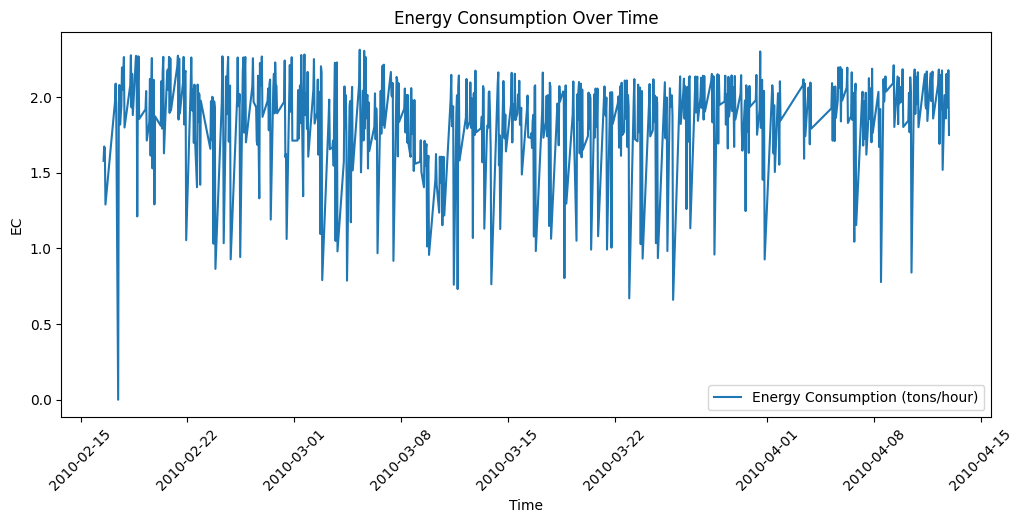

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(df['Hour'], df['EC'], label="Energy Consumption (tons/hour)")
plt.xlabel("Time")
plt.ylabel("EC")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

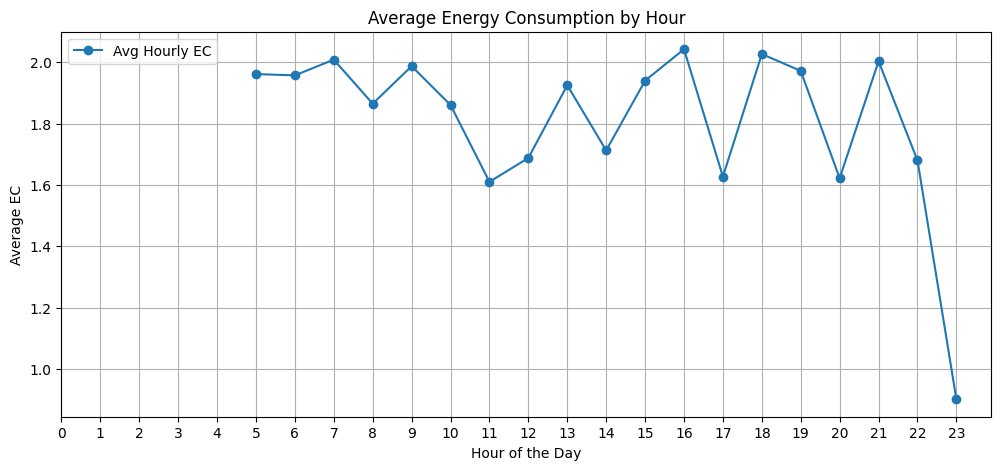

In [46]:
# Group by hour of the day
hourly_ec = df.groupby('hour').agg({'EC': 'mean'}).reset_index()

plt.figure(figsize=(12, 5))
plt.plot(hourly_ec['hour'], hourly_ec['EC'], marker='o', linestyle='-', label="Avg Hourly EC")
plt.xlabel("Hour of the Day")
plt.ylabel("Average EC")
plt.title("Average Energy Consumption by Hour")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

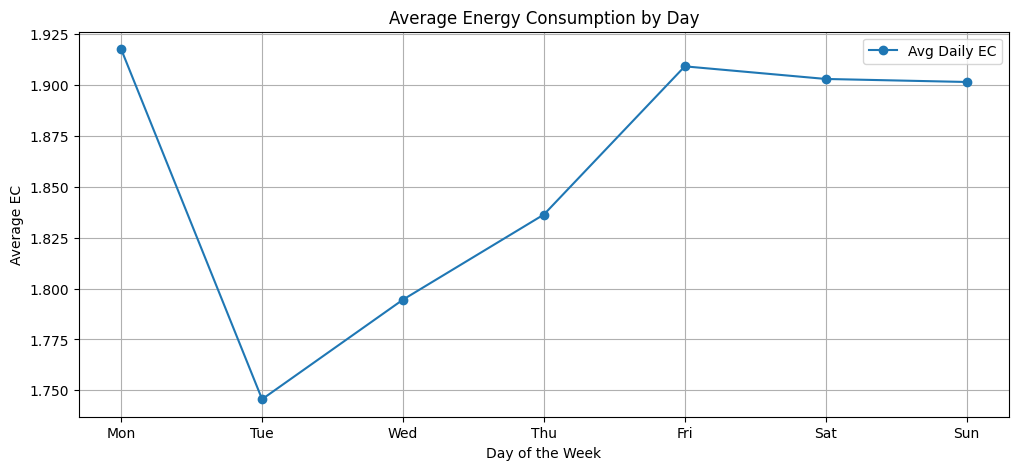

In [47]:
# Group by day of the week
daily_ec = df.groupby('day').agg({'EC': 'mean'}).reset_index()

plt.figure(figsize=(12, 5))
plt.plot(daily_ec['day'], daily_ec['EC'], marker='o', linestyle='-', label="Avg Daily EC")
plt.xlabel("Day of the Week")
plt.ylabel("Average EC")
plt.title("Average Energy Consumption by Day")
plt.xticks(range(0, 7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.legend()
plt.grid(True)
plt.show()

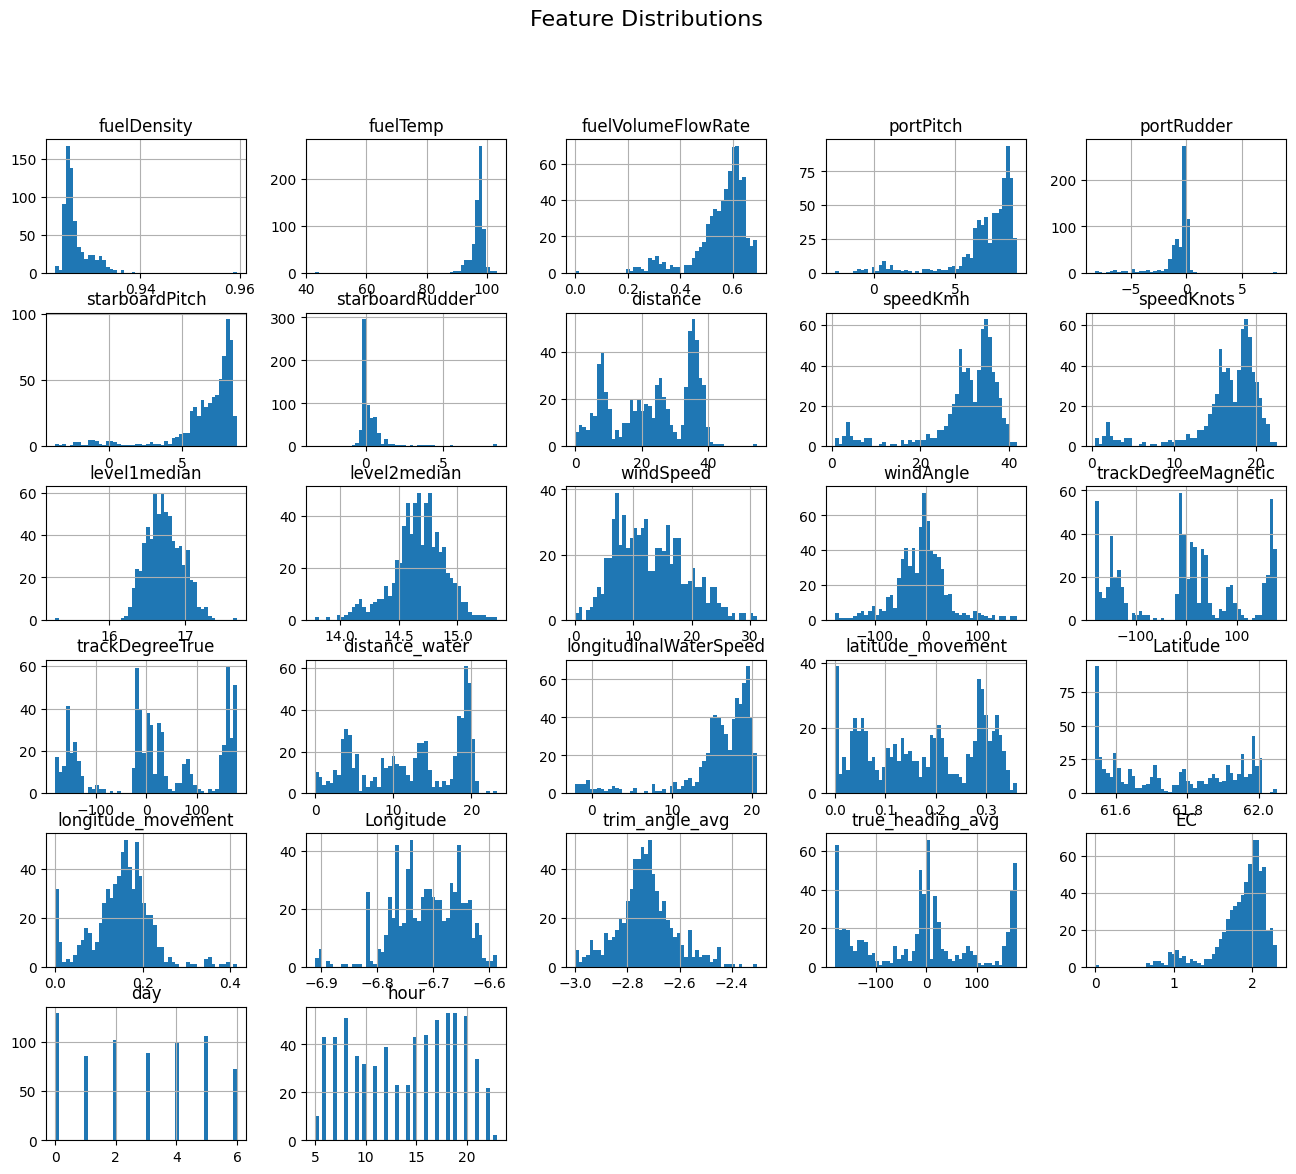

In [48]:
# Plot distribution of features
df.drop(columns=['Hour']).hist(figsize=(16, 13), bins=50)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

##Correlation Analysis

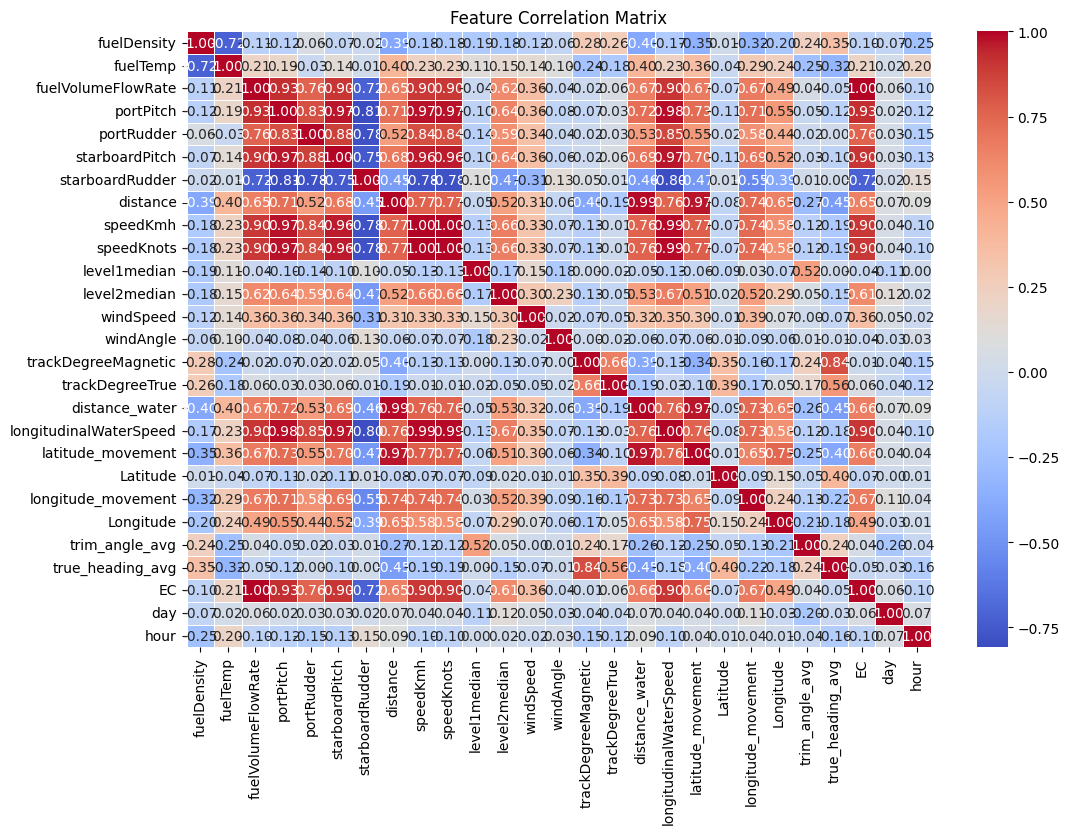

In [49]:
df_numeric = df.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

First, I deleted columns having low correlations with EC

In [50]:
# Correlation with EC
ec_corr = corr_matrix["EC"].abs()  # Take absolute values to consider both positive & negative correlations

# Select columns with correlation >= 0.3
selected_features = ec_corr[ec_corr >= 0.3].index.tolist()


df = df[selected_features]
print("Remaining Features:", df.columns.tolist())
print(f"\nUpdated dataset shape: {df.shape}")


Remaining Features: ['fuelVolumeFlowRate', 'portPitch', 'portRudder', 'starboardPitch', 'starboardRudder', 'distance', 'speedKmh', 'speedKnots', 'level2median', 'windSpeed', 'distance_water', 'longitudinalWaterSpeed', 'latitude_movement', 'longitude_movement', 'Longitude', 'EC']

Updated dataset shape: (683, 16)


In [51]:
corr_matrix = df.corr()
ec_corr = corr_matrix['EC'].abs().sort_values(ascending=False)

print("Sorted Correlations with EC:\n")
print(ec_corr)

Sorted Correlations with EC:

EC                        1.000000
fuelVolumeFlowRate        0.999876
portPitch                 0.925090
starboardPitch            0.903612
longitudinalWaterSpeed    0.903090
speedKmh                  0.897678
speedKnots                0.897677
portRudder                0.761536
starboardRudder           0.719028
longitude_movement        0.669223
latitude_movement         0.663742
distance_water            0.660123
distance                  0.647087
level2median              0.614292
Longitude                 0.488213
windSpeed                 0.358079
Name: EC, dtype: float64


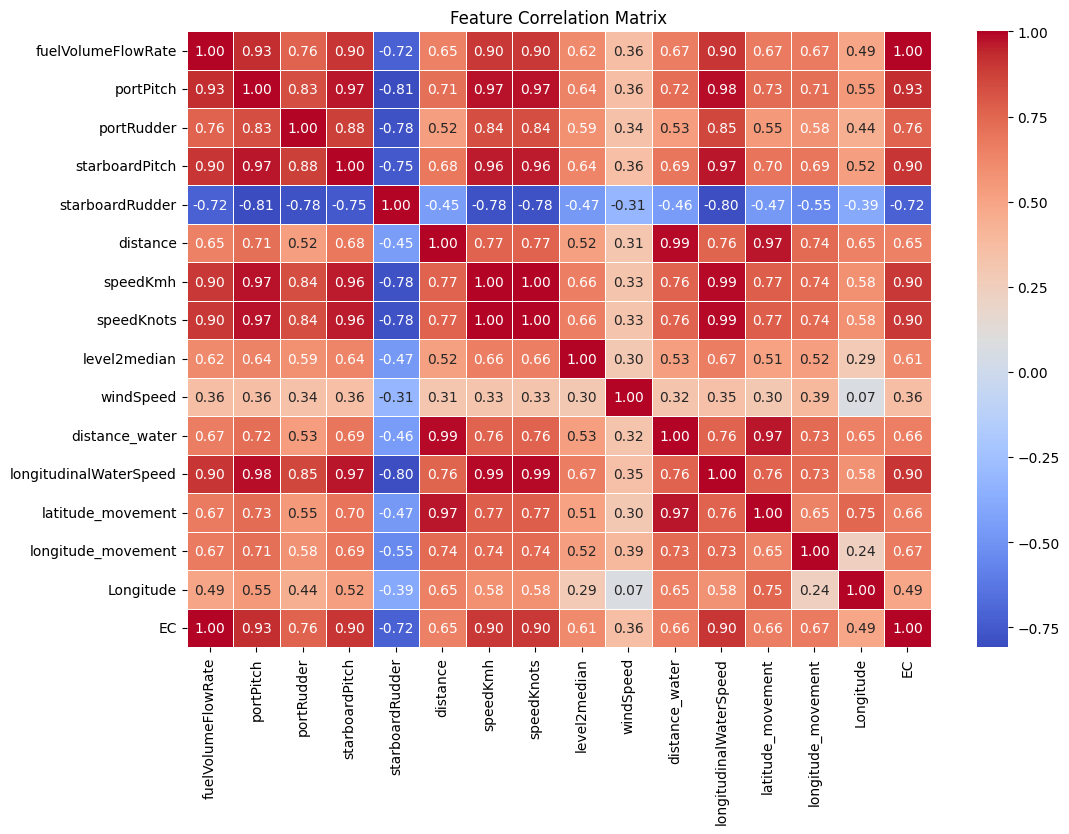

In [52]:
df_numeric = df.select_dtypes(include=['number'])

corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

Some columns were highly correlated with each other, which could cause redundancy and multicollinearity. Thus, I selected only the features with high correlation to EC while removing weakly correlated or redundant ones to improve model stability and interpretability.

In [53]:
df = df.drop(columns=['fuelVolumeFlowRate', # removed because this is used in calcaulation of EC
                      'distance', #97% correlation with latitude_movement, and that variable is more correlated with EC
                      'distance_water', #97% correlation with latitude_movement, and that variable is more correlated with EC
                      'speedKmh', #97% correlation with portPitch, and that variable is more correlated with EC
                      'speedKnots', #97% correlation with portPitch, and that variable is more correlated with EC
                      'longitudinalWaterSpeed' #97% correlation with portPitch, and that variable is more correlated with EC
                      # I don't have domain knowledge; thus, I kept portPitch and standartPitch although they were 97% correlated
                      ])

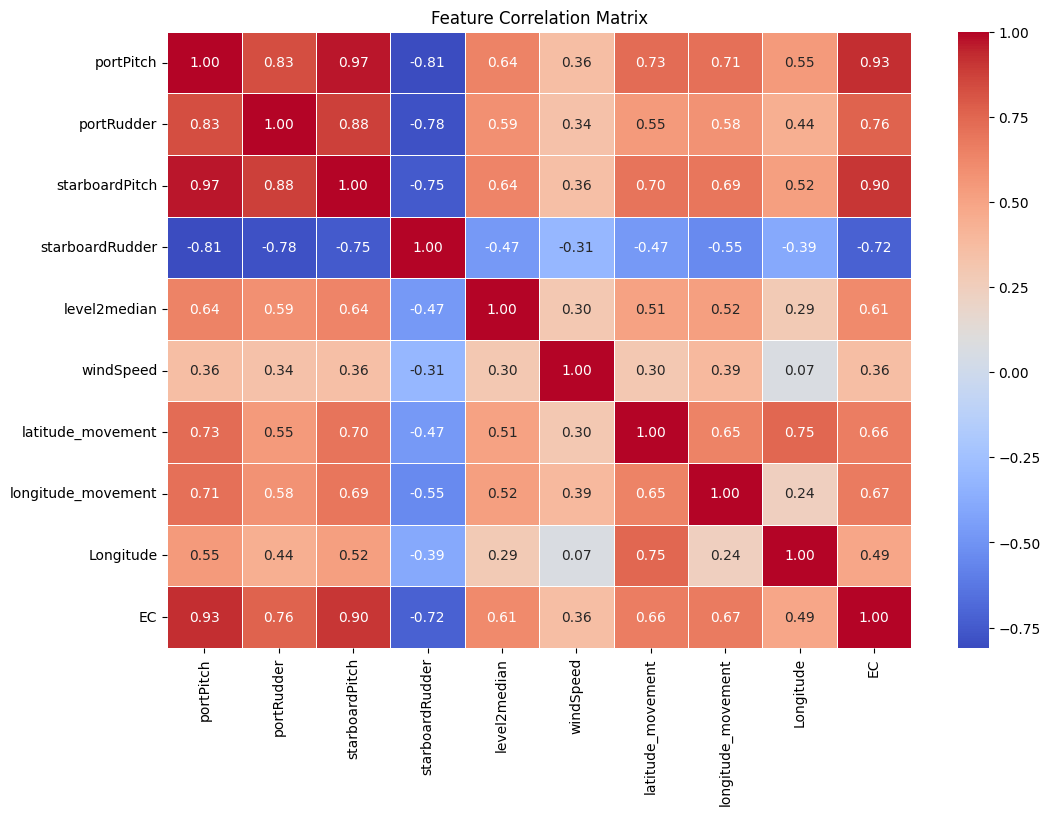

In [54]:
df_numeric = df.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

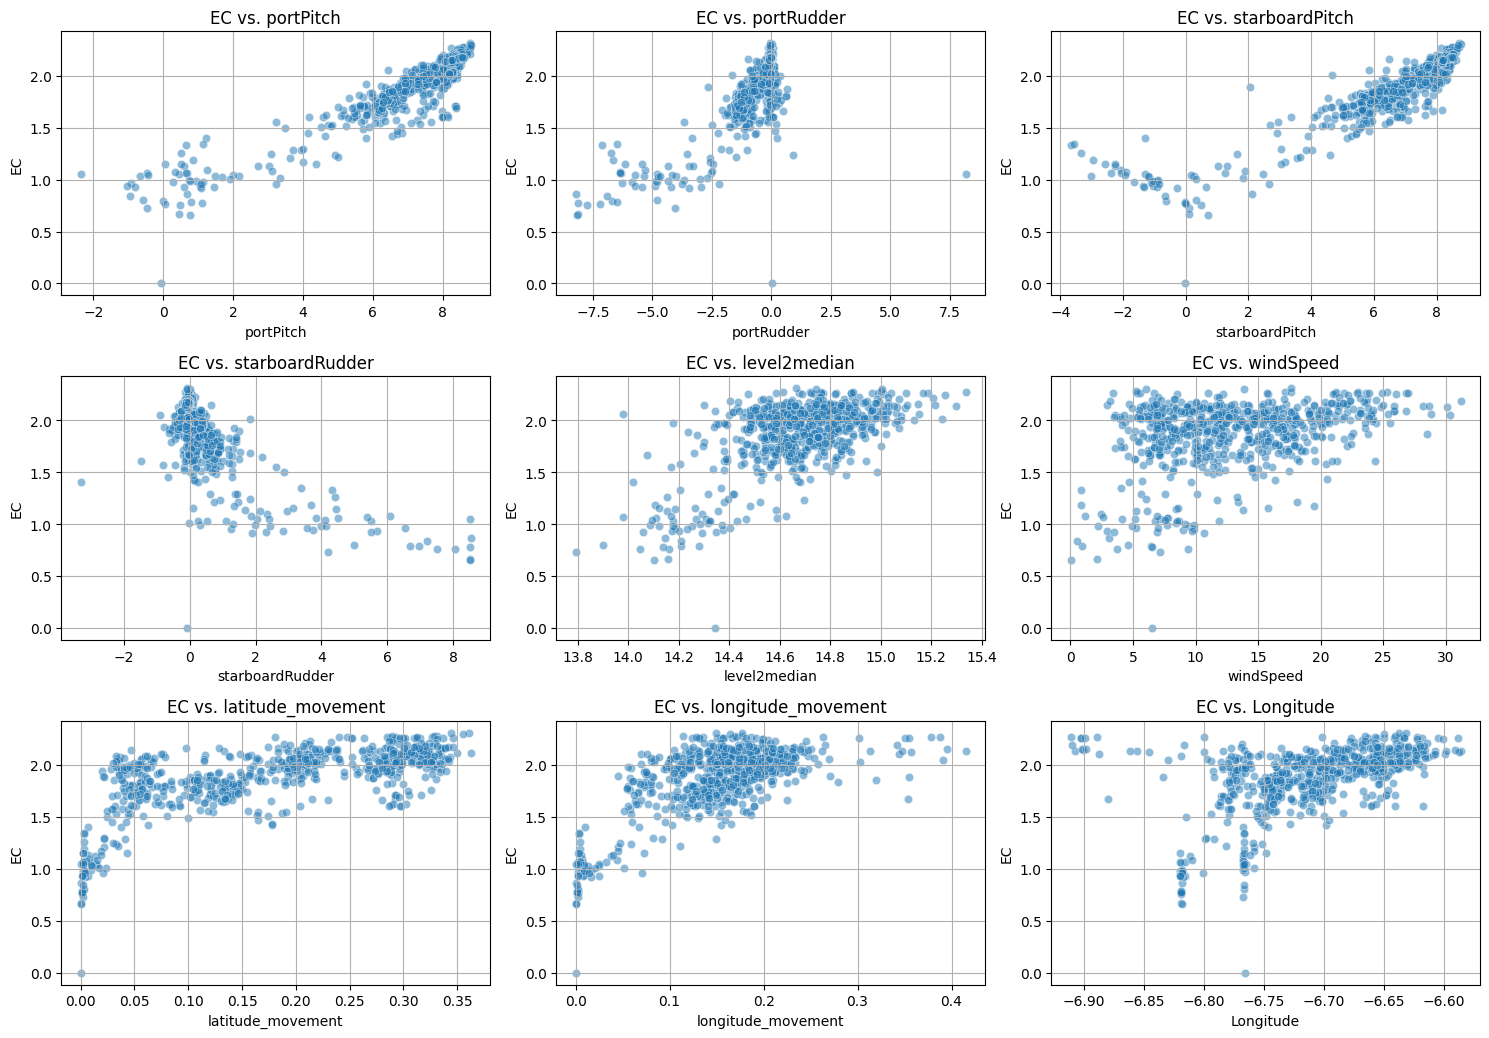

In [55]:
#Scatter plots
num_features = df.select_dtypes(include=['number']).columns.tolist()
num_features.remove('EC')


fig, axes = plt.subplots(nrows=len(num_features)//3 + 1, ncols=3, figsize=(15, len(num_features)*1.5))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.scatterplot(x=df[feature], y=df['EC'], alpha=0.5, ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("EC")
    axes[i].set_title(f"EC vs. {feature}")
    axes[i].grid(True)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Modeling

## Training

In [56]:
#Define X and y
y = df['EC']
X = df.drop(columns=['EC'])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Feature columns:", X.columns.tolist())

Shape of X: (683, 9)
Shape of y: (683,)
Feature columns: ['portPitch', 'portRudder', 'starboardPitch', 'starboardRudder', 'level2median', 'windSpeed', 'latitude_movement', 'longitude_movement', 'Longitude']


In [57]:
# First, 80% train and 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, from temp, 50% test and 50% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Set: {X_train.shape[0]} rows")
print(f"Validation Set: {X_val.shape[0]} rows")
print(f"Test Set: {X_test.shape[0]} rows")

Training Set: 546 rows
Validation Set: 68 rows
Test Set: 69 rows


In [58]:
#Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [59]:
# First, try some models with default parameters
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVM": SVR(),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred)
    results[name] = {"R² Score": r2, "RMSE": rmse}


print("\nModel Performance Comparison (Validation Set):")
for model, scores in results.items():
    print(f"{model}: R² = {scores['R² Score']:.4f}, RMSE = {scores['RMSE']:.4f}")


Model Performance Comparison (Validation Set):
Linear Regression: R² = 0.8954, RMSE = 0.0147
Decision Tree: R² = 0.9195, RMSE = 0.0113
Random Forest: R² = 0.9411, RMSE = 0.0083
Gradient Boosting: R² = 0.9449, RMSE = 0.0078
SVM: R² = 0.9257, RMSE = 0.0105
XGBoost: R² = 0.9344, RMSE = 0.0092


## Evaluation on Validation Set

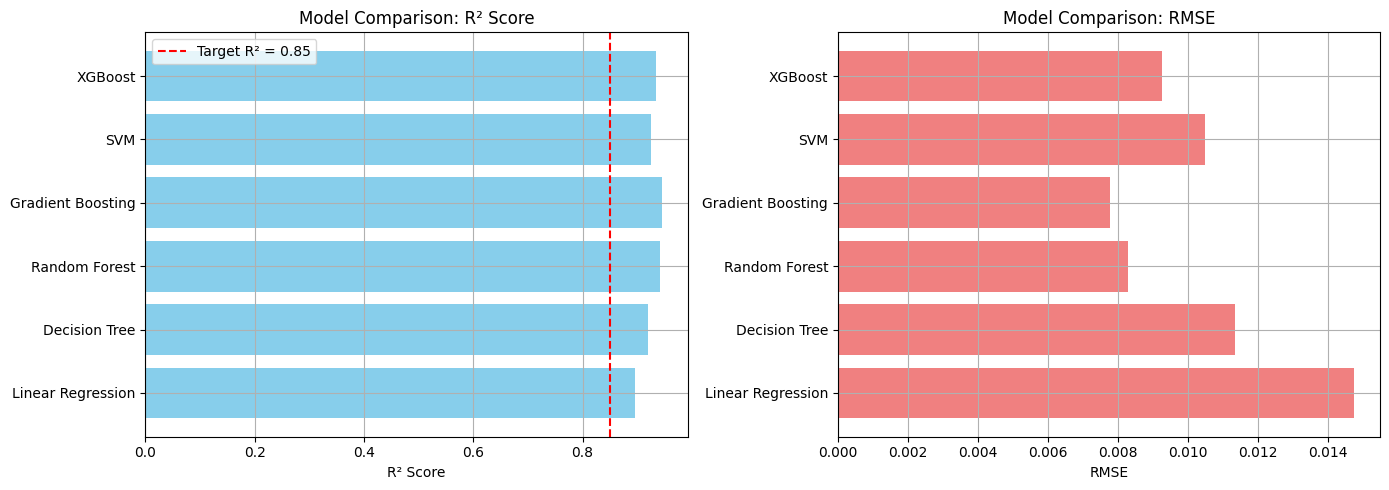

In [60]:
model_names = list(results.keys())
r2_scores = [results[m]["R² Score"] for m in model_names]
rmse_scores = [results[m]["RMSE"] for m in model_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for R² Score
axes[0].barh(model_names, r2_scores, color="skyblue")
axes[0].set_xlabel("R² Score")
axes[0].set_title("Model Comparison: R² Score")
axes[0].axvline(x=0.85, color='red', linestyle='--', label="Target R² = 0.85")
axes[0].legend()
axes[0].grid(True)

# Bar plot for RMSE
axes[1].barh(model_names, rmse_scores, color="lightcoral")
axes[1].set_xlabel("RMSE")
axes[1].set_title("Model Comparison: RMSE")
axes[1].grid(True)

plt.tight_layout()
plt.show()

##Hyperparameter Tuning & Evaluation on Test Set

I selected best two models for hyperparameter tuning: Gradient Boosting and Random Forest

In [61]:
# Define hyperparameter grids
gb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 10],  # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Initialize models
gb_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Grid search for Gradient Boosting
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='r2', n_jobs=-1)
gb_grid_search.fit(X_train_scaled, y_train)

# Grid search for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='r2', n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

# Get best models
best_gb = gb_grid_search.best_estimator_
best_rf = rf_grid_search.best_estimator_

# Print best parameters
print("\nBest Gradient Boosting Parameters:", gb_grid_search.best_params_)
print("\nBest Random Forest Parameters:", rf_grid_search.best_params_)



Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [62]:
# Evaluate best models on validation & test sets
gb_results = evaluate_model(best_gb, X_val_scaled, y_val, X_test_scaled, y_test, "Gradient Boosting")
rf_results = evaluate_model(best_rf, X_val_scaled, y_val, X_test_scaled, y_test, "Random Forest")


📊 Gradient Boosting Performance:
Validation R²: 0.9552, Validation RMSE: 0.0063
Test R²: 0.8587, Test RMSE: 0.0149

📊 Random Forest Performance:
Validation R²: 0.9415, Validation RMSE: 0.0082
Test R²: 0.8954, Test RMSE: 0.0110


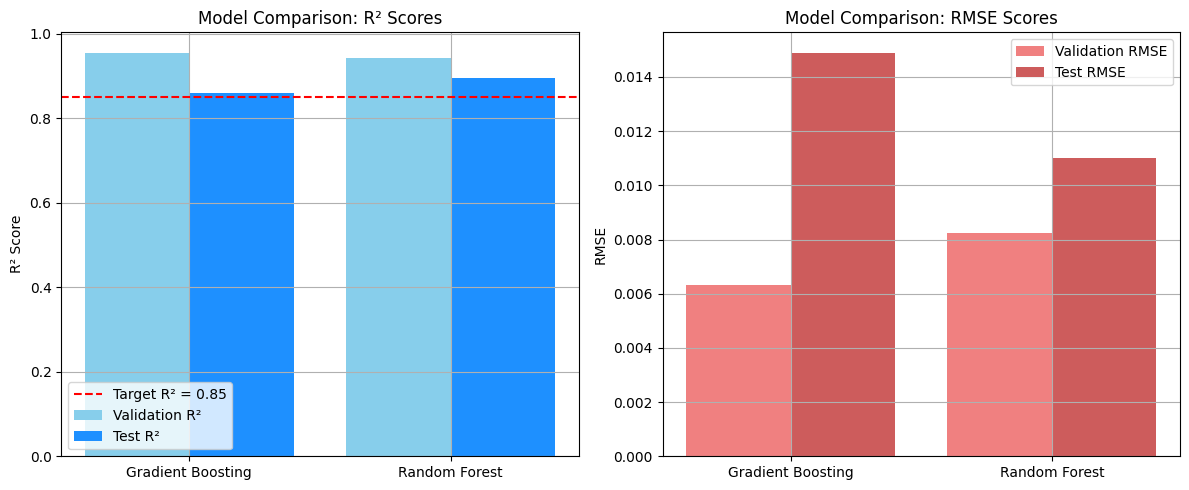

In [63]:
models = ["Gradient Boosting", "Random Forest"]

# R² Scores
r2_scores = [
    [gb_results["Validation R²"], gb_results["Test R²"]],
    [rf_results["Validation R²"], rf_results["Test R²"]]
]

# RMSE Scores
rmse_scores = [
    [gb_results["Validation RMSE"], gb_results["Test RMSE"]],
    [rf_results["Validation RMSE"], rf_results["Test RMSE"]]
]

# Plot R² Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bar_width = 0.4
x = np.arange(len(models))
plt.bar(x - bar_width/2, [r2[0] for r2 in r2_scores], bar_width, label="Validation R²", color="skyblue")
plt.bar(x + bar_width/2, [r2[1] for r2 in r2_scores], bar_width, label="Test R²", color="dodgerblue")
plt.xticks(x, models)
plt.ylabel("R² Score")
plt.title("Model Comparison: R² Scores")
plt.axhline(y=0.85, color='red', linestyle='--', label="Target R² = 0.85")
plt.legend()
plt.grid(True)

# Plot RMSE Scores
plt.subplot(1, 2, 2)
plt.bar(x - bar_width/2, [rmse[0] for rmse in rmse_scores], bar_width, label="Validation RMSE", color="lightcoral")
plt.bar(x + bar_width/2, [rmse[1] for rmse in rmse_scores], bar_width, label="Test RMSE", color="indianred")
plt.xticks(x, models)
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE Scores")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


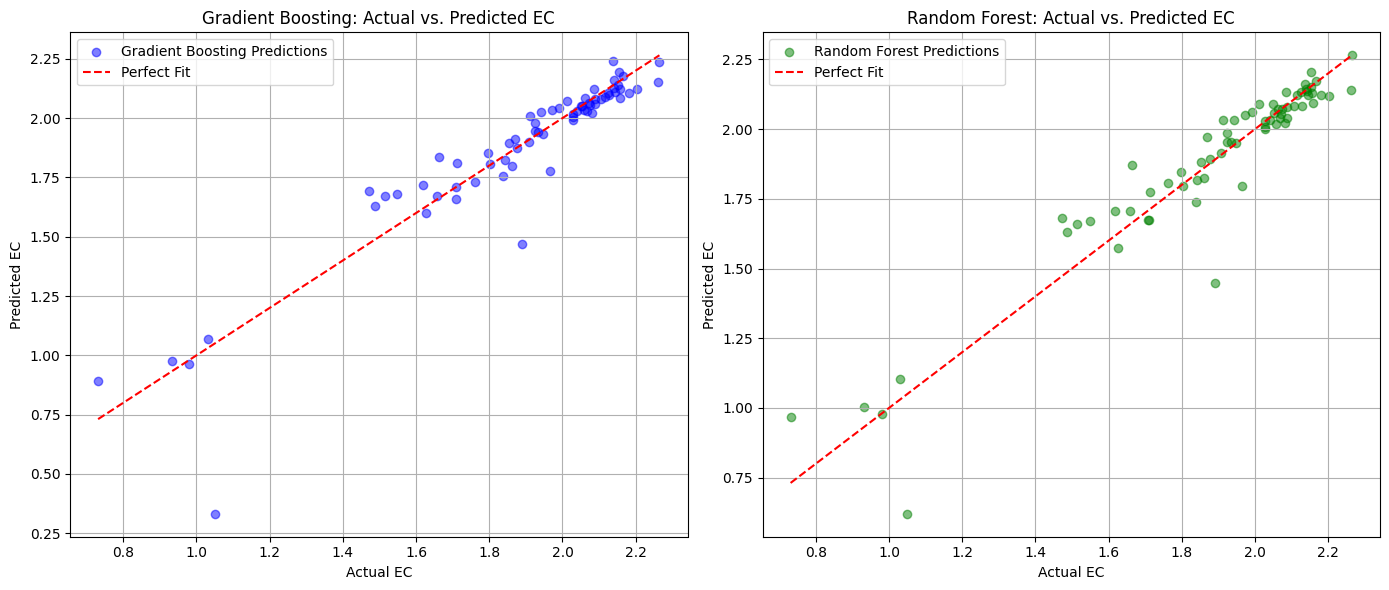

In [64]:
# Predictions on test set
y_test_pred_gb = best_gb.predict(X_test_scaled)
y_test_pred_rf = best_rf.predict(X_test_scaled)

plt.figure(figsize=(14, 6))

# SVM Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_gb, alpha=0.5, color="blue", label="Gradient Boosting Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Fit")
plt.xlabel("Actual EC")
plt.ylabel("Predicted EC")
plt.title("Gradient Boosting: Actual vs. Predicted EC")
plt.legend()
plt.grid(True)

# Random Forest Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, color="green", label="Random Forest Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Fit")
plt.xlabel("Actual EC")
plt.ylabel("Predicted EC")
plt.title("Random Forest: Actual vs. Predicted EC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-65-76e1170db3e4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


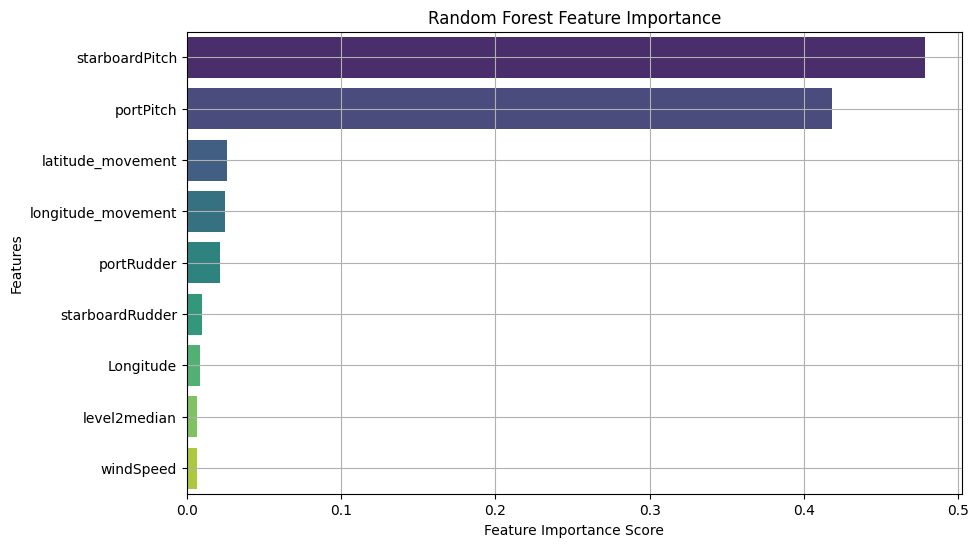

In [65]:
# Feature importance
feature_importance = best_rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.grid(True)
plt.show()